# Show how pySOT works for a simple 1d example to gain intuition about the sampling pattern

In [2]:
# Import the necessary modules
from pySOT import *
from poap.controller import SerialController, BasicWorkerThread
import numpy as np

# Decide how many evaluations we are allowed to use
maxeval = 30

# (1) Optimization problem
# Use the 1-dimensional Rastrigin function
data = Rastrigin(dim=1)
print(data.info)

# (2) Experimental design
# Use a Latin hypercube with 4d samples
exp_des = LatinHypercube(dim=data.dim, npts=4*data.dim)

# (3) Surrogate model
# Use a cubic RBF interpolant with a linear tail
surrogate = RBFInterpolant(kernel=CubicKernel, tail=LinearTail, maxp=maxeval)

# (4) Adaptive sampling
# Use SRBF with 100d candidate points
adapt_samp = CandidateSRBF(data=data, numcand=100*data.dim)

1-dimensional Rastrigin function 
Global optimum: f(0,0,...,0) = 0


In [3]:
# Use the serial controller (uses only one thread)
controller = SerialController(data.objfunction)

# (5) Use the sychronous strategy without non-bound constraints
strategy = SyncStrategyNoConstraints(
        worker_id=0, data=data, maxeval=maxeval, nsamples=1,
        exp_design=exp_des, response_surface=surrogate, 
        sampling_method=adapt_samp)
controller.strategy = strategy

# Run the optimization strategy
result = controller.run()

## Replay the sampling

<IPython.core.display.Javascript object>


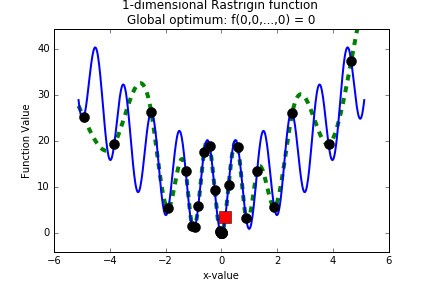

In [4]:
%matplotlib inline
%matplotlib nbagg
import matplotlib.pyplot as plt
import time

xlin = np.atleast_2d(np.linspace(data.xlow[0], data.xup[0], 500)).T

# Extract evluations from the controller
xvals = np.array([o.params[0] for o in controller.fevals])
fvals = np.array([o.value for o in controller.fevals])
yfun = np.zeros(500,)
for i in range(500):
    yfun[i] = data.objfunction(xlin[i])

# Show the surrogate at each step as well
surrogate.reset()
for i in range(exp_des.npts):
    surrogate.add_point(xvals[i], fvals[i])
yrbf = surrogate.evals(xlin)

fig, ax = plt.subplots()
rbf_lines, = ax.plot(xlin, yfun, 'g--', linewidth=4.0)
fun_lines, = ax.plot(xlin, yrbf, 'b-', linewidth=2.0)
pts, = ax.plot(xvals[:exp_des.npts], fvals[:exp_des.npts], 'ko', markersize=10)
newpt, = ax.plot(xvals[exp_des.npts], fvals[exp_des.npts], 'rs', markersize=12)
plt.show()

plt.xlabel('x-value')
plt.ylabel('Function Value')
plt.title(data.info)

ymin = np.min(yfun)
ymax = np.max(yfun)
ax.set_ylim(ymin - 0.1*(ymax - ymin), ymax + 0.1*(ymax - ymin))
ax.relim()

for i in range(exp_des.npts, maxeval): 
    # Add the new point
    pts.set_xdata(xvals[:i])
    pts.set_ydata(fvals[:i])
    newpt.set_xdata(xvals[i])
    newpt.set_ydata(fvals[i])
    
    # Update the RBF
    surrogate.add_point(xvals[i], fvals[i])
    yrbf = surrogate.evals(xlin)
    rbf_lines.set_ydata(yrbf)
    fun_lines.set_ydata(yfun)
    
    # Update plot
    fig.canvas.draw()
    time.sleep(1)

## Exercise: Experiment with different functions and settings and see what happens to the sampling pattern

## Written by, David Eriksson, dme65@cornell.edu